In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import pyLDAvis

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, ensemble,decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import silhouette_score

import  textblob
from xgboost import XGBClassifier

#Importing Gensim
import gensim
from gensim import corpora

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
from textblob import Word
from imblearn.over_sampling import RandomOverSampler

#settings
color = sns.color_palette()
sns.set_style("dark")

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

%matplotlib inline

ModuleNotFoundError: No module named 'pandas'

In [ ]:
online_job_postings = pd.read_csv('data job posts.csv')

In [ ]:
online_job_postings.head()

In [ ]:
#Most of the variables are not required for analysis. so we select only the required variable and then impute missing values
online_job_postings = online_job_postings[['jobpost','Title','Company','JobDescription',
                                           'JobRequirment','RequiredQual','Year','Month',
                                           'AboutC','IT']]

In [ ]:
#Checking for missing data
online_job_postings_missing = online_job_postings.isna()
num_missing = online_job_postings_missing.sum()
num_missing

In [ ]:
(num_missing/len(online_job_postings)).round(2)

In [ ]:
online_job_postings[['Title',
                     'Company',
                     'JobDescription',
                     'JobRequirment',
                     'RequiredQual',
                     'AboutC']] = online_job_postings[['Title',
                                                       'Company',
                                                       'JobDescription',
                                                       'JobRequirment',
                                                       'RequiredQual',
                                                       'AboutC']].fillna(online_job_postings[['Title',
                                                                                              'Company',
                                                                                              'JobDescription',
                                                                                              'JobRequirment',
                                                                                              'RequiredQual',
                                                                                              'AboutC']].mode().iloc[0])

In [ ]:
#Checking for missing data
online_job_postings_missing = online_job_postings.isna()
num_missing = online_job_postings_missing.sum()
num_missing

In [ ]:
df = online_job_postings

In [ ]:
#Exploratory data analysis

df['jobpost'] = df['jobpost'].astype(str)
df['count_sent'] = df["jobpost"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df['count_word'] = df["jobpost"].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word'] = df["jobpost"].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters'] = df["jobpost"].apply(lambda x: len(str(x)))

#Word density

df['word_density'] = df['count_letters'] / (df['count_word']+1)

#punctuation count
df["count_punctuations"] = df["jobpost"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["jobpost"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
df["count_words_lower"] = df["jobpost"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
df["count_words_title"] = df["jobpost"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Average length of the words
df["mean_word_len"] = df["jobpost"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
df['numeric'] = df['jobpost'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
df['alphanumeric'] = df['jobpost'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
df['alphabetetics'] = df['jobpost'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
df['Spaces'] = df['jobpost'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
df['words_ends_with_et'] = df['jobpost'].apply(lambda x :len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
df['words_start_with_no'] = df['jobpost'].apply(lambda x :len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
df['wordcounts'] = df['jobpost'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

In [ ]:
df.head()

# Sentiment Analysis

In [ ]:
df['Sentiment'] = df['jobpost'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
df['sentiment_cat'] = np.where(df.Sentiment > 0,'Positive', np.where(df.Sentiment == 0,'Neutral','Negative'))

In [ ]:
df.head()

In [ ]:
#Splitting data
X = df.jobpost
y = df.IT

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [ ]:
#UDF to clean the text
import string
stop = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'((www.\.[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,']", "", text)
    return(text)

In [ ]:
def pre_process(text):
    text = text.str.replace('/','')                       
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return(text)

In [ ]:
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [ ]:
X_train = pre_process(X_train)
X_test = pre_process(X_test)

In [ ]:
#Making a copy of X train and test for Topic modelling
lda_Train = X_train 
lda_Test = X_test

In [ ]:
#Creating a frequency DTM
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' ,
                             max_features=800)

xtrain_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

In [ ]:
dtm = pd.DataFrame(xtrain_count.toarray())

In [ ]:
#Adding columns to DTM
dtm.columns = count_vect.get_feature_names()

In [24]:
dtm.head()

,ability,able,access,accordance,according,account,accountant,accounting,accuracy,accurate,...,working,world,would,write,writing,written,wv,wwwcareercenteram,year,yerevan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,1
1,2,0,0,1,1,0,0,6,0,1,...,0,0,0,0,1,1,0,2,2,1
2,1,0,0,0,0,3,0,3,1,0,...,0,0,0,0,0,0,0,2,0,1
3,2,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,2,1,1
4,3,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,1,0,2,0,1


## Word Cloud and Bar Graph

In [25]:
word_freq = pd.DataFrame(dtm.apply(sum).head(20), columns=['freq'])
word_freq.sort_values('freq', ascending=False, inplace=True)

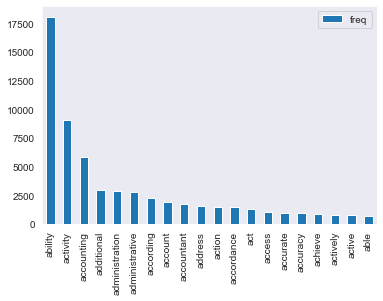

In [26]:
word_freq.plot(kind='bar')

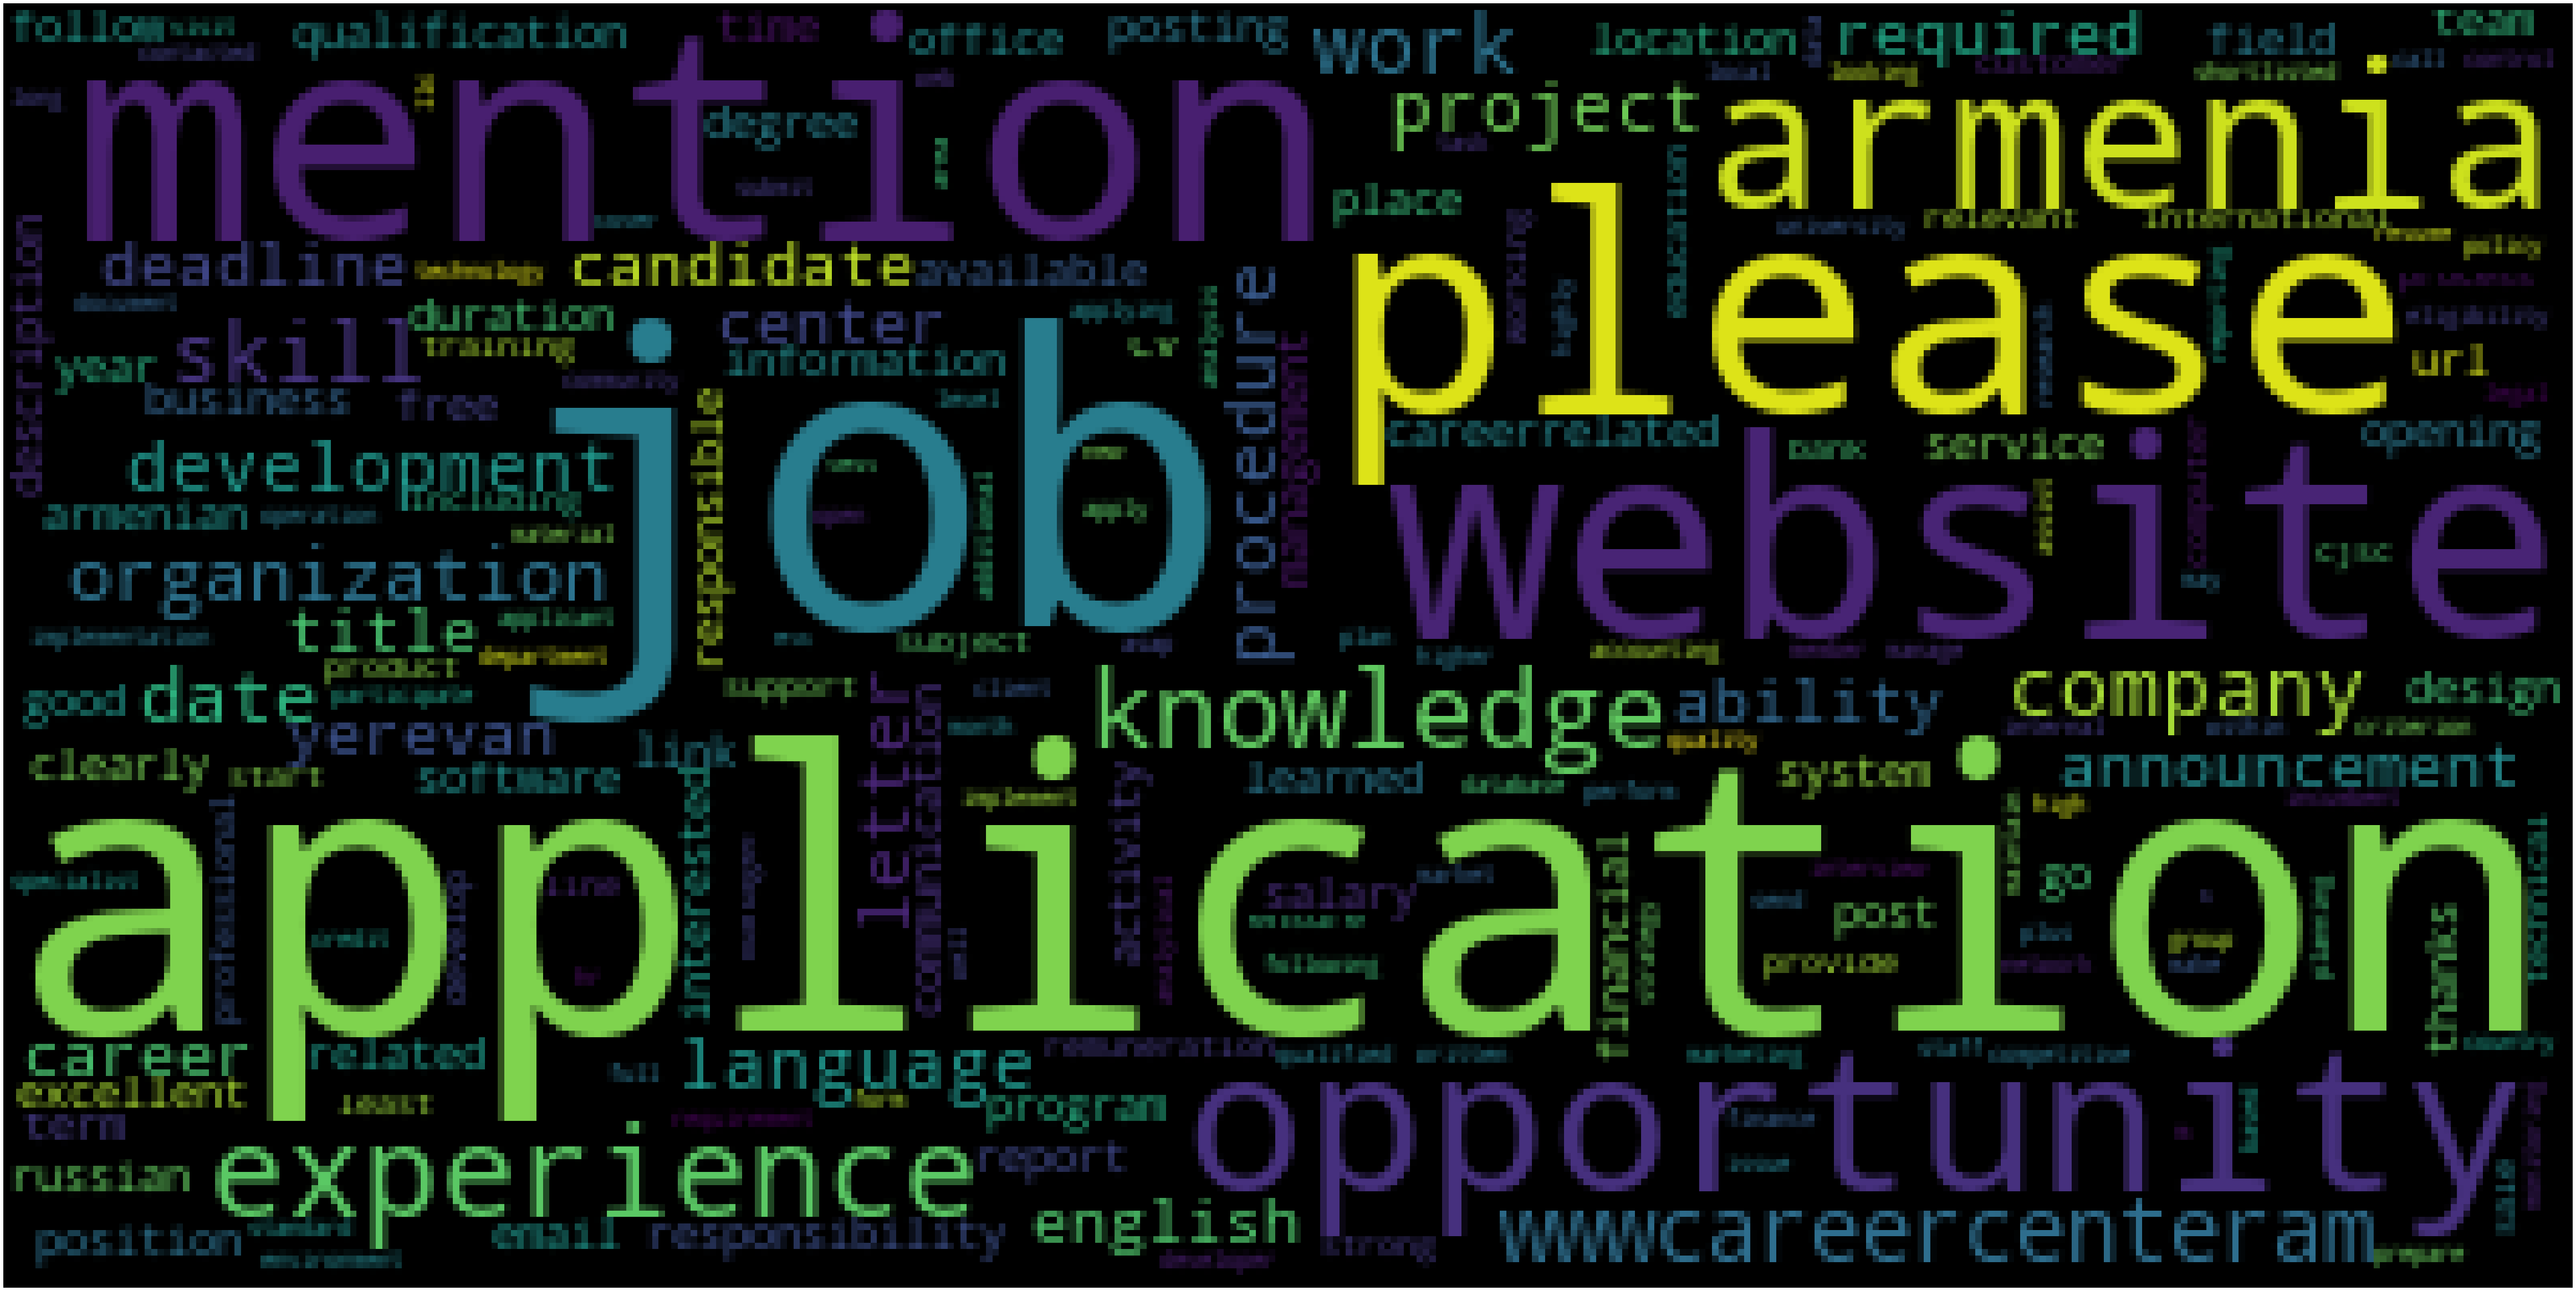

In [27]:
#Generating word clouds
word_freq = dict(dtm.apply(sum))
wordcloud = WordCloud(background_color='black', stopwords=stop)

wordcloud = wordcloud.generate_from_frequencies(word_freq)
fig = plt.figure(1, figsize=(150, 50))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Classification

In [28]:
#Checking if the y variable is balanced
np.unique(y_train,return_counts=True)

(array([False,  True]), array([11453,  2797], dtype=int64))

In [29]:
#Checking if the y variable is balanced
np.unique(y_test,return_counts=True)

(array([False,  True]), array([3789,  962], dtype=int64))

## The variable is not balanced. It has very less number of True's.We need to perform over or under sampling to make the variable balanced. In this case, i went with over sampling of the lower class.

In [30]:
#Handling imbalance data for train
random_sample = RandomOverSampler(random_state = 111)
X_train,y_train = random_sample.fit_sample(xtrain_count,y_train)

In [31]:
np.unique(y_train,return_counts=True)

(array([False,  True]), array([11453, 11453], dtype=int64))

In [32]:
#Handling imbalance data for test
random_sample = RandomOverSampler(random_state = 1137)
X_test,y_test = random_sample.fit_sample(X_test_count,y_test)

In [33]:
np.unique(y_test,return_counts=True)

(array([False,  True]), array([3789, 3789], dtype=int64))

In [34]:
#Classification using Logistic Regression
logistic_reg = LogisticRegression(max_iter = 1000,n_jobs = -1)
logistic_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [35]:
#Accuracy on train data
logistic_reg.score(X_train, y_train)

0.9558630926394831

In [36]:
#Predictions on test data
y_pred_class = logistic_reg.predict(X_test)
print('Accuracy using Logistic Regression is',metrics.accuracy_score(y_test, y_pred_class))

Accuracy using Logistic Regression is 0.9088149907627342


In [37]:
#Good ness of fit metrics based on categorical predicted output for train & test
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

       False       0.89      0.94      0.91      3789
        True       0.93      0.88      0.91      3789

    accuracy                           0.91      7578
   macro avg       0.91      0.91      0.91      7578
weighted avg       0.91      0.91      0.91      7578



In [38]:
fpr_test,tpr_test,treshold_test = metrics.roc_curve(y_test,y_pred_class)
roc_auc_test = metrics.auc(fpr_test,tpr_test)

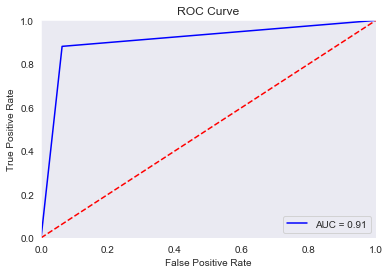

In [39]:
#Test AUC
plt.title('ROC Curve')
plt.plot(fpr_test,tpr_test,'b',label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(0.5, 16.0, 'Predicted Class')

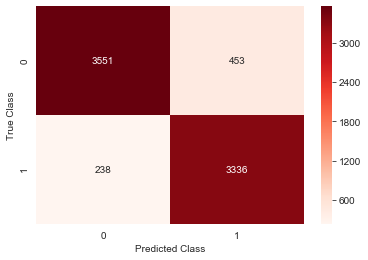

In [40]:
#Confusion matrix
final_cm = (metrics.confusion_matrix(y_pred_class,y_test))
sns.heatmap(final_cm,annot = True, cmap = 'Reds',fmt = 'd')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [41]:
#Classification using XGB Classifier
xgb_estimator = XGBClassifier(n_estimators = 400,
                         random_state = 1137,
                        n_jobs=-1,learning_rate = 0.5)
xgb_estimator.fit(X_train, y_train)

XGBClassifier(learning_rate=0.5, n_estimators=400, n_jobs=-1, random_state=1137)

In [42]:
#Accuracy on train data
xgb_estimator.score(X_train, y_train)

0.999694403213132

In [55]:
#Predicting on test data
y_pred_class = xgb_estimator.predict(X_test)
print('Accuracy using XGB Classifier is',metrics.accuracy_score(y_test, y_pred_class))

Accuracy using XGB Classifier is 0.930588545790446


In [44]:
#Good ness of fit metrics based on categorical predicted output for train & test
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

       False       0.90      0.97      0.93      3789
        True       0.97      0.89      0.93      3789

    accuracy                           0.93      7578
   macro avg       0.93      0.93      0.93      7578
weighted avg       0.93      0.93      0.93      7578



In [45]:
fpr_test,tpr_test,treshold_test = metrics.roc_curve(y_test,y_pred_class)
roc_auc_test = metrics.auc(fpr_test,tpr_test)

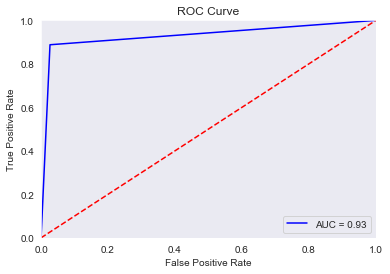

In [46]:
#Test AUC
plt.title('ROC Curve')
plt.plot(fpr_test,tpr_test,'b',label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(0.5, 16.0, 'Predicted Class')

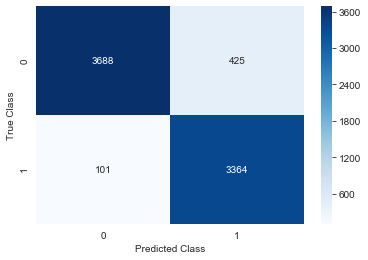

In [47]:
#Confusion matrix
final_cm = (metrics.confusion_matrix(y_pred_class,y_test))
sns.heatmap(final_cm,annot = True, cmap = 'Blues',fmt = 'd')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [145]:
#Classification using RF Classifier and gridsearch
param_grid = {'max_depth': [5,6,7,8,9], 'n_estimators':[50,100,200,300,400,500], 'max_features':[4,5,6,7]}
RF_GCV_model = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv = 10,n_jobs = -1,verbose = 1)
RF_GCV_model = RF_GCV_model.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 35.5min finished


In [147]:
RF_GCV_model.best_score_

0.9091943221910685

In [148]:
#Accuracy on train data
RF_GCV_model.score(X_train, y_train)

0.9149131231991617

In [149]:
#Predicting on test data
y_pred_class = RF_GCV_model.predict(X_test)
print('Accuracy using RF Classifier is',metrics.accuracy_score(y_test, y_pred_class))

Accuracy using RF Classifier is 0.8991818421747163


In [150]:
#Good ness of fit metrics based on categorical predicted output for train & test
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

       False       0.87      0.93      0.90      3789
        True       0.93      0.86      0.90      3789

    accuracy                           0.90      7578
   macro avg       0.90      0.90      0.90      7578
weighted avg       0.90      0.90      0.90      7578



In [151]:
fpr_test,tpr_test,treshold_test = metrics.roc_curve(y_test,y_pred_class)
roc_auc_test = metrics.auc(fpr_test,tpr_test)

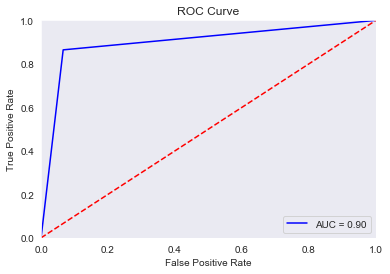

In [152]:
#Test AUC
plt.title('ROC Curve')
plt.plot(fpr_test,tpr_test,'b',label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(0.5, 16.0, 'Predicted Class')

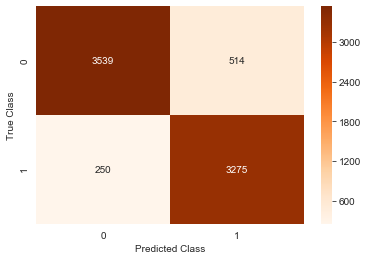

In [161]:
#Confusion matrix
final_cm = (metrics.confusion_matrix(y_pred_class,y_test))
sns.heatmap(final_cm,annot = True, cmap = 'Oranges',fmt = 'd')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [48]:
#Classification using Naive Bayes
nb_clf = naive_bayes.MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

In [49]:
#Accuracy on train data
nb_clf.score(X_train, y_train)

0.8930411245961757

In [50]:
#Predicting on test data
y_pred_class = nb_clf.predict(X_test)
print('Accuracy using Naive Bayes Classifier is',metrics.accuracy_score(y_test, y_pred_class))

Accuracy using Naive Bayes Classifier is 0.9034045922406968


In [51]:
#Good ness of fit metrics based on categorical predicted output for train & test
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

       False       0.90      0.90      0.90      3789
        True       0.90      0.90      0.90      3789

    accuracy                           0.90      7578
   macro avg       0.90      0.90      0.90      7578
weighted avg       0.90      0.90      0.90      7578



In [52]:
fpr_test,tpr_test,treshold_test = metrics.roc_curve(y_test,y_pred_class)
roc_auc_test = metrics.auc(fpr_test,tpr_test)

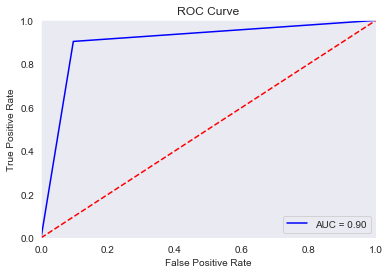

In [53]:
#Test AUC
plt.title('ROC Curve')
plt.plot(fpr_test,tpr_test,'b',label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(0.5, 16.0, 'Predicted Class')

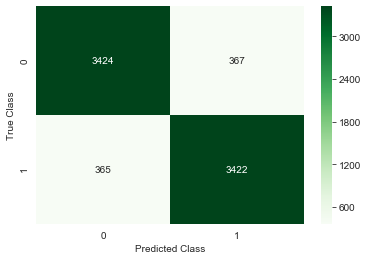

In [54]:
#Confusion matrix
final_cm = (metrics.confusion_matrix(y_pred_class,y_test))
sns.heatmap(final_cm,annot = True, cmap = 'Greens',fmt = 'd')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

## Of all the above built classification models, XGB classification model gave me the best accuracy of 99% on train data and on the test data it gave me 93% accuracy.So i would go ahead with XGB classification model for further classification in the future.

In [ ]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
#Initializing Neural Network
classifier = Sequential()

In [ ]:
# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 30, init = 'uniform', activation = 'relu', input_dim = 24))
# Adding the second hidden layer
classifier.add(Dense(output_dim = 30, init = 'uniform', activation = 'relu'))
# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

In [ ]:
# Compiling Neural Network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Fitting our model 
classifier.fit(std_data_train, train_y, batch_size = 10, nb_epoch = 100)

In [ ]:
classifier.summary()

In [ ]:
classifier.get_weights()

In [ ]:
# Predicting the Train set results
y_pred_train = classifier.predict(std_data_train)

In [ ]:
y_pred_train = (y_pred_train > 0.11)

In [ ]:
# Creating the Confusion Matrix
cm_train = confusion_matrix(train_y, y_pred_train)

In [ ]:
cm_train

In [ ]:
print(classification_report(train_y, y_pred_train))

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(std_data_test)
y_pred = (y_pred > 0.11)

In [ ]:
# Creating the Confusion Matrix
cm = confusion_matrix(test_y, y_pred)

In [ ]:
cm

In [ ]:
print(classification_report(test_y, y_pred))

# Cluster Analysis

C:\Users\PHANI KUMAR\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\PHANI KUMAR\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\PHANI KUMAR\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\PHANI KUMAR\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\PHANI KUMAR\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n

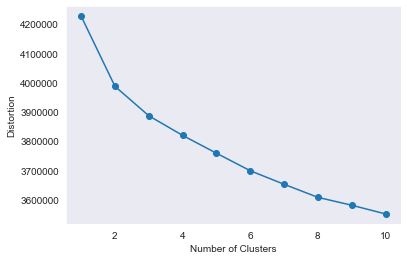

In [59]:
#Elbow method for k value estimation for K - means
Distortion = []
for i in range(1,11):
    KM = KMeans(n_clusters = i,max_iter = 500,n_jobs = -1)
    KM.fit(xtrain_count)
    
    Distortion.append(KM.inertia_)

plt.plot(range(1,11),cost,marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

### Optimum value of K is 3

In [60]:
k_val = 3
km_mod = KMeans(n_clusters = k_val, init = 'k-means++', max_iter = 100, n_init=1,n_jobs = -1)
km_mod.fit(xtrain_count)

C:\Users\PHANI KUMAR\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(max_iter=100, n_clusters=3, n_init=1, n_jobs=-1)

In [61]:
print("Top terms per cluster:")
print('----------------------')
order_centroids = km_mod.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(k_val):
    print('-----------')
    print("Cluster %d:" % i),
    print('-----------')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),

Top terms per cluster:
----------------------
-----------
Cluster 0:
-----------
 job
 application
 mention
 please
 website
 opportunity
 wwwcareercenteram
 armenia
 knowledge
 company
-----------
Cluster 1:
-----------
 application
 job
 experience
 knowledge
 software
 development
 please
 website
 mention
 company
-----------
Cluster 2:
-----------
 project
 armenia
 application
 job
 development
 experience
 work
 management
 organization
 skill


## Topic Mining

In [63]:
X_train_tokens = [doc.split() for doc in lda_Train]

In [64]:
dictionary = corpora.Dictionary(X_train_tokens)

In [65]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in X_train_tokens]

In [66]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics = 11, id2word = dictionary, passes = 1)
topics = ldamodel.show_topics(formatted = False, num_words = 100)

In [67]:
#Build LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components = 20, max_iter = 10, learning_decay = 0.9,
                                                    learning_method = 'online', random_state = 1137,
                                                    batch_size = 128, evaluate_every = -1, n_jobs = -1)
lda_model.fit_transform(xtrain_count)

array([[3.73134340e-04, 3.73134335e-04, 8.66001153e-02, ...,
        3.73134337e-04, 3.73134335e-04, 3.73134336e-04],
       [1.71821310e-04, 2.61693816e-01, 1.71821310e-04, ...,
        1.71821309e-04, 1.71821309e-04, 1.71821309e-04],
       [1.08307347e-01, 3.67647065e-04, 3.14173365e-01, ...,
        3.67647066e-04, 3.67647068e-04, 3.67647065e-04],
       ...,
       [2.46305425e-04, 3.65715232e-01, 4.68054405e-01, ...,
        2.46305424e-04, 2.46305424e-04, 2.46305424e-04],
       [3.03951210e-02, 6.58608151e-01, 8.25082525e-05, ...,
        8.25082524e-05, 8.53399872e-03, 8.25082525e-05],
       [3.10559014e-04, 3.10559013e-04, 2.98393364e-01, ...,
        3.10559012e-04, 3.10559012e-04, 3.10559013e-04]])

In [68]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(xtrain_count))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(xtrain_count))

Log Likelihood:  -15724309.10080932
Perplexity:  332.3906993612703


In [69]:
lda_model.n_components = 20

In [70]:
#Create Document - Topic Matrix
lda_output = lda_model.transform(xtrain_count)

#Column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

#Index names
docnames = ["Doc" + str(i) for i in range(len(lda_Train))]

#Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topicnames, index = docnames)

#Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis = 1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.00,0.00,0.09,0.84,0.0,0.07,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,3
Doc1,0.00,0.26,0.00,0.00,0.0,0.00,0.03,0.0,0.0,0.0,...,0.53,0.05,0.12,0.00,0.00,0.01,0.00,0.0,0.0,11
Doc2,0.11,0.00,0.31,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,0.43,0.00,0.14,0.00,0.00,0.0,0.0,13
Doc3,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.35,0.00,0.00,0.00,0.00,0.65,0.0,0.0,17
Doc4,0.00,0.00,0.22,0.00,0.0,0.17,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.06,0.00,0.03,0.00,0.0,0.0,10


In [71]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.sort_values(by = "Topic Num").reset_index(drop=True).head()

,Topic Num,Num Documents
0,0,580
1,1,1414
2,2,4548
3,3,692
4,4,643


In [72]:
#Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

#Assign Column and Index
df_topic_keywords.columns = count_vect.get_feature_names()
df_topic_keywords.index = topicnames

#View
df_topic_keywords.head()

,ability,able,access,accordance,according,account,accountant,accounting,accuracy,accurate,...,working,world,would,write,writing,written,wv,wwwcareercenteram,year,yerevan
Topic0,1447.718605,12.335400,0.829193,64.614244,255.296040,120.392763,0.250015,209.314281,144.794418,41.330719,...,61.396240,0.050836,0.058547,0.326733,13.230400,159.097848,0.050405,967.556392,501.965317,313.000894
Topic1,2006.648105,17.467602,304.287144,260.195637,160.968723,11.789918,0.183797,0.118973,7.366713,68.574273,...,1417.792786,380.542518,118.057990,79.108414,547.658657,780.251795,2.323226,953.070272,1378.683543,917.537665
Topic2,2858.897993,50.541998,40.129294,3.309048,77.154603,5.713464,0.055671,0.377591,180.264933,23.551839,...,887.663060,33.604523,259.905920,175.737704,194.111254,697.403897,0.051952,10240.530346,1911.466947,6065.987049
Topic3,512.353246,0.051449,2.269178,1.021990,17.472091,0.060521,0.050474,0.056269,0.052244,0.579841,...,280.038991,0.053060,56.141149,234.982388,126.469598,335.059179,0.050442,1486.885863,671.105070,860.617277
Topic4,209.968079,2.065422,1.995901,0.059823,141.295910,0.074826,0.050491,0.050769,0.055548,0.050831,...,135.755963,0.057503,2.683862,15.859200,14.144509,146.233163,0.050385,1704.614219,873.519177,1412.882759


In [73]:
# Show top n keywords for each topic
def show_topics(vectorizer = count_vect, lda_model = lda_model, n_words = 20):
    keywords = np.array(count_vect.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer = count_vect, lda_model = lda_model, n_words = 11)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,bank,management,skill,job,business,financial,knowledge,application,process,company,cjsc
Topic 1,project,development,management,armenia,activity,program,implementation,experience,work,international,support
Topic 2,job,application,mention,website,please,opportunity,wwwcareercenteram,armenia,company,date,knowledge
Topic 3,application,software,job,design,development,experience,please,engineer,mention,website,opportunity
Topic 4,application,job,form,bank,announcement,attachment,website,mention,opportunity,knowledge,wwwcareercenteram
Topic 5,design,experience,application,data,ability,skill,job,team,database,business,work
Topic 6,system,network,application,job,security,information,knowledge,support,technical,experience,administration
Topic 7,child,community,armenia,health,development,world,program,vision,skill,job,ensure
Topic 8,test,testing,qa,tool,quality,knowledge,job,application,ability,experience,assurance
Topic 9,legal,law,application,job,legislation,knowledge,work,ra,contract,document,armenia
